# Predicting Temperature using Graph Neural Networks


In this Notebook, we will predict temperature measurements across various countries, using altitude and temperature data of very few neighboring countries (Weakly Supervised Learning).
We will use a Graph Neural Network based model.

#### Module Installation

In [1]:
!pip install networkx 
!conda install -c dglteam dgl-cuda10.1 -y
 
# used for distance calculation between cities
!pip install geopy

# used for visualizing the graphs
!pip install graphviz
!pip install cgraph
!conda install python-graphviz -y
!pip install pygraphviz


     |████████████████████████████████| 1.6 MB 698 kB/s eta 0:00:01
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - dgl-cuda10.1

Current channels:

  - https://conda.anaconda.org/dglteam/osx-64
  - https://conda.anaconda.org/dglteam/noarch
  - https://conda.anaconda.org/bioconda/osx-64
  - https://conda.anaconda.org/bioconda/noarch
  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch
  - https://conda.anaconda.org/conda-forge/osx-64
  - https://conda.anaconda.org/conda-forge/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the

#### Module Import

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx
from geopy.distance import distance
import geopy
import requests
import urllib
import os.path as osp
import torch
import torch.nn.functional as F
import itertools
from dgl.nn.pytorch import GraphConv, SAGEConv

from random import shuffle, randint
import networkx as nx
import matplotlib.pyplot as plt


import dgl
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import pickle as pkl




DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


#### Data Proccessing
We will use data from the dataset "Climate Change: Earth Surface Temperature Data" which is available on Kaggle - https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv

This dataset has many temperature samples, we will only use samples from the USA in a single day.
To enrich the data, we will obtain the altitude of each city.


In [46]:
# get data from here - 
# read data, take only data for USA at the most recent date (day)
all_df = pd.read_csv('../GlobalLandTemperaturesByCity.csv')
usa_df = all_df[all_df['Country']=="United States"]

# create a unique city identifier (more than opne measurement per city)
usa_df['city_id'] = usa_df['City'] + usa_df["Latitude"] + usa_df["Longitude"]

# remove duplicates - TODO Asaf - Do we need this??

# remove_idx_list = []
# for date in usa_df['dt'].unique():
#     date_df= usa_df.loc[usa_df['dt']==date]
#     date_df['coords'] = date_df["Latitude"] + date_df["Longitude"]
#     usa_df = usa_df.drop_duplicates(subset="coords")  # remove duplicates


/Users/iamit/opt/anaconda3/envs/py37_scicomp/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [47]:
# Create a city list from most recent day
city_list = usa_df.loc[usa_df['dt']=="2013-05-01", 'city_id'].unique()
n_city_list = len(city_list)

# Remove cities without recent measurements
usa_df = usa_df.loc[usa_df['city_id'].isin(city_list)]

# Remove days with partial measurements
remove_idx_list = []
for date in usa_df['dt'].unique():
    date_city_series = usa_df.loc[usa_df['dt']==date, 'city_id']
    if date_city_series.shape[0] < n_city_list:
        remove_idx_list += list(date_city_series.index)
        
# Remove cities with more than one measurments 

usa_df.drop(index=remove_idx_list, inplace=True)

In [48]:
print("Number of cities in the Dataset = {}".format(n_city_list))
print("Number of days in the Dataset = {}. From {} to {}.".format(usa_df['dt'].nunique(), min(usa_df['dt']), max(usa_df['dt'])))

Number of cities in the Dataset = 257
Number of days in the Dataset = 1977. From 1849-01-01 to 2013-09-01.


In [51]:
df = usa_df
df = df.fillna(0)


In [54]:
# Add elevation for each lat-long - takes ~1sec per coordinate
# USGS Elevation Point Query Service - needs a different format of points, so casted by geopy
url = r'https://nationalmap.gov/epqs/pqs.php?'


"""Query service using lat, lon. add the elevation values as a new column."""
elevations = dict()
for city_id in usa_df['city_id'].unique():
    city_df = usa_df.loc[usa_df['city_id'] == city_id]
    lat = city_df["Latitude"].values[0]
    lon = city_df["Longitude"].values[0]
    pos = geopy.Point.from_string(lat + " " + lon)
    # query params
    params = {
        'output': 'json',
        'x': pos.longitude, 
        'y': pos.latitude, 
        'units': 'Meters'
    }

    # format query string and return query value
    result = requests.get((url + urllib.parse.urlencode(params)))
    elevations[city_id] = result.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation']

df['elev_meters'] = df['city_id'].apply(lambda x: elevations[x])

# df = df[df['elev_meters'] != '-1000000']  # remove nodes with faulty values - Needed? can be used as NA to the network. 

# In order to run the Notebook faster, the dataframe will be stored in memory
df.to_pickle("usa_data.pkl")

df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,city_id,elev_meters
47903,1849-01-01,5.131,3.482,Abilene,United States,32.95N,100.53W,Abilene32.95N100.53W,631.85
47904,1849-02-01,6.776,1.929,Abilene,United States,32.95N,100.53W,Abilene32.95N100.53W,631.85
47905,1849-03-01,13.135,1.859,Abilene,United States,32.95N,100.53W,Abilene32.95N100.53W,631.85
47906,1849-04-01,17.381,2.626,Abilene,United States,32.95N,100.53W,Abilene32.95N100.53W,631.85
47907,1849-05-01,20.393,1.379,Abilene,United States,32.95N,100.53W,Abilene32.95N100.53W,631.85


In [57]:
# And here, it can be loaded again...
df = pd.read_pickle("usa_data.pkl")


In [70]:
# Dictnoary with distances between cities 
city_dict = dict()  # key (city_id, city_id), value - distance
for city_a  in df['city_id'].unique():
    for city_b  in df['city_id'].unique():
        city_a_df = df.loc[df['city_id'] == city_a]
        city_b_df = df.loc[df['city_id'] == city_b]
        pos1 = geopy.Point.from_string(city_a_df["Latitude"].values[0] + " " + city_a_df["Longitude"].values[0])
        pos2 = geopy.Point.from_string(city_b_df["Latitude"].values[0] + " " + city_b_df["Longitude"].values[0])
        dist = float(distance(pos1, pos2).meters)  # geopy distance
        dist = np.asarray([dist])
        city_dict[(city_a, city_b)] = dist
        
# In order to run the Notebook faster, the dictonary will be stored in memory
with open("city_distance.pkl", 'wb') as file:
    pkl.dump(city_dict, file)

AttributeError: '_io.BufferedWriter' object has no attribute 'dump'

In [72]:
# And here, it can be loaded again...
with open("city_distance.pkl", 'rb') as file:
    city_dict = pkl.load(file)

In [73]:
city_dict

{('Abilene32.95N100.53W', 'Abilene32.95N100.53W'): array([0.]),
 ('Abilene32.95N100.53W', 'Akron40.99N80.95W'): array([1952373.20026384]),
 ('Abilene32.95N100.53W',
  'Albuquerque34.56N107.03W'): array([627998.79212017]),
 ('Abilene32.95N100.53W', 'Alexandria39.38N76.99W'): array([2227244.66468687]),
 ('Abilene32.95N100.53W', 'Allentown40.99N74.56W'): array([2467128.57624722]),
 ('Abilene32.95N100.53W', 'Amarillo34.56N101.19W'): array([188755.4971149]),
 ('Abilene32.95N100.53W', 'Anaheim32.95N117.77W'): array([1610231.52646004]),
 ('Abilene32.95N100.53W', 'Anchorage61.88N151.13W'): array([4794211.34736582]),
 ('Abilene32.95N100.53W', 'Ann Arbor42.59N82.91W'): array([1879290.81696295]),
 ('Abilene32.95N100.53W', 'Antioch37.78N122.03W'): array([2020947.28605806]),
 ('Abilene32.95N100.53W', 'Arlington32.95N96.70W'): array([358107.82952189]),
 ('Abilene32.95N100.53W', 'Arlington39.38N76.99W'): array([2227244.66468687]),
 ('Abilene32.95N100.53W', 'Arvada39.38N106.13W'): array([873028.166158

# GNN - Graph Nueral Network

Below, a graph structure is built from the data.
Each city (temperature sample) will be a node in the graph. Each city has temperature and altitude features.

For each city, we calculate distances to all other cities, and take the 10 nearest cities, and link them via an edge. Each edge is weighed by the distance. There are no self loops.

In [3]:
# create the graph - both nx and dgl (converting from nx to dgl failed )
graph= networkx.Graph()
g = dgl.DGLGraph()
num_neighbors = 10


for idx, row in enumerate(df.iterrows()):
    avg_temp = float(row[1]["AverageTemperature"])
    elevation = float(row[1]["elev_meters"])

    temp = np.asarray([avg_temp], dtype=np.float32)
    height = np.asarray([elevation], dtype=np.float32)

    graph.add_node(idx, city_name=row[1]["City"], temp=temp, height=height)
    g.add_nodes(1, {'temp': torch.from_numpy(temp), 'height':torch.from_numpy(height)})


for idx1, row1 in enumerate(df.iterrows()):
    v_e_dict = {}
    dists_sorted = []
    for idx2, row2 in enumerate(df.iterrows()):
        pos1 = geopy.Point.from_string(row1[1]["Latitude"] + " " + row1[1]["Longitude"])
        pos2 = geopy.Point.from_string(row2[1]["Latitude"] + " " + row2[1]["Longitude"])
        distance = float(distance(pos1, pos2).meters)  # geopy distance
        distance = np.asarray([distance])
        v_e_dict[idx2] = distance  # for this city1, for each city2, save dist in dict
        dists_sorted.append(distance)

    # go over distances, add only X closest neighbors
    dists_sorted.sort()
    dists_sorted = dists_sorted[0:num_neighbors+1]

    for ii, dist in enumerate(v_e_dict.items()):
        city, distance_ = dist
        if distance_ > 0 and distance_ in dists_sorted:
            ### graph.add_edge(row1[1]["City"], row2[1]["City"], distance=distance)
            graph.add_edge(idx1, city, distance=distance_)
            g.add_edge(idx1, city, {'distance':torch.from_numpy(distance_)})




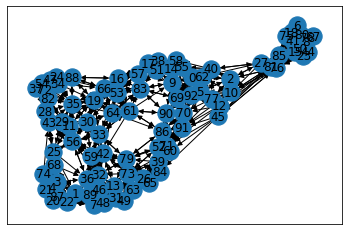

In [590]:
# networkx.draw(graph, with_labels=True, font_weight='bold')


nx.draw_networkx(g.to_networkx())
plt.show()

# from networkx.drawing.nx_agraph import graphviz_layout
# pos = graphviz_layout(graph)
# plt.axis('off')
# nx.draw_networkx_nodes(graph,pos,node_color='g',alpha = 0.8)  # draws nodes
# nx.draw_networkx_edges(graph,pos,edge_color='b',alpha = 0.6)  # draws edges
# nx.draw_networkx_edge_labels(graph,pos,edge_labels = nx.get_edge_attributes(graph,'weight')) # edge lables
# nx.draw_networkx_labels(graph,pos) # node lables

In [4]:
# find a dominating set of vertices which can be used for learning the rest of the vertices

from networkx.algorithms.dominating import dominating_set
g_nx = g.to_networkx()

# # to create our dataset, mimic missing measurements by finding some independent set of graph
# we will attempt to learn it!
remove = dominating_set(g_nx)

keep = np.asarray(list(set(np.arange(len(g_nx))) - remove), dtype=np.int64)
remove = np.asarray(list(remove), dtype=np.int64)
len(keep) + len(remove)
len(remove)

14

#### The Model used - Weighed Graph Convolutions
We will use a 3 layer Graph Convolution Network.
Instead of summing the neighbors features to each node, the aggregation function will take a weighted mean of each neighbors' features. 
A softmax function will be used to create probablity-like weights from the distance of each node. We will take a complement of this (1 minus the result) in order for closer nodes to affect the features more than the further ones.


In [5]:
class WeighedGraphConv(nn.Module):

    def __init__(self,
                 in_feats,
                 out_feats,
                 num_neighbors, 
                 weight=True,
                 bias=True):
        super(WeighedGraphConv, self).__init__()

        self._in_feats = in_feats
        self._out_feats = out_feats
        self.num_neighbors = num_neighbors

        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        torch.nn.init.xavier_uniform_(self.weight)

        self.bias = nn.Parameter(torch.Tensor(out_feats))          


    def forward(self, graph, feat, weight=None):
        graph = graph.local_var()
        # normalize input features
        degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
        norm = torch.pow(degs, -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)
        feat = feat * norm

        weight = self.weight

        # mult W first to reduce the feature size for aggregation.
        if weight is not None:
            feat = torch.matmul(feat, weight)
        graph.srcdata['h'] = feat

        efeat = graph.edges[:].data['distance'].unsqueeze(-1)
        efeat = F.softmax(efeat.view(self.num_neighbors, -1), dim=0)
        efeat = 1 - efeat
        efeat = efeat.flatten()

        # (n, d_in, d_out)
        graph.edata['ee'] = efeat
        graph.update_all(fn.u_mul_e('h', 'ee', 'm'), fn.sum('m', 'h'))

        # graph.update_all(fn.copy_src(src='h', out='m'), fn.mean(msg='m', out='h'))
        rst = graph.dstdata['h']

        if self.bias is not None:
            rst = rst + self.bias


        return rst



TanH functions are used in between the layers. 
The nodes have 5-dimension features which are initialized with a normal distribution.

In [34]:
class Net(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes, num_neighbors):
        super(Net, self).__init__()
        self.conv1 = WeighedGraphConv(5, 5, num_neighbors)
        self.conv2 = WeighedGraphConv(5, 5, num_neighbors)
        self.conv3 = WeighedGraphConv(5, 2, num_neighbors)


    def forward(self, g, feats_):

        h = self.conv1(g, feats_)
        h = torch.tanh(h)
        # h = torch.nn.functional.leaky_relu(h, 0.1)
        h = self.conv2(g, h)
        h = torch.tanh(h)
        # h = torch.nn.functional.leaky_relu(h, 0.1)
        h = self.conv3(g, h)
        return h

net = Net(5, 5, 2, num_neighbors)  # num_of_classes = temp, altitude
print(net)

embed = nn.Embedding(len(g), 5)  # |g| nodes with embedding dim equal to 5

Net(
  (conv1): WeighedGraphConv()
  (conv2): WeighedGraphConv()
  (conv3): WeighedGraphConv()
)


#### Training and Validation
We will only use the dominating set of nodes for supervision. The rest of the node features will be learned.
We train for 300 epochs.
Adam optimizer and MSE loss were used.


In [35]:

# data for training
labeled_nodes = torch.from_numpy(remove) # only a small part of the nodes are used for supervision
labeled_temp = g.nodes[labeled_nodes].data['temp']
labeled_height = g.nodes[labeled_nodes].data['height']
labels = torch.stack([labeled_temp, labeled_height], dim=1) # their labels are their height + temp

# data for validation
unlabeled_nodes = torch.from_numpy(keep)
unlabeled_temp = g.nodes[unlabeled_nodes].data['temp']
unlabeled_height = g.nodes[unlabeled_nodes].data['height']
unlabels = torch.stack([unlabeled_temp, unlabeled_height], dim=1) # their labels are their height + temp

features = embed.weight

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=0.5)
num_epochs = 300

losses = []
accuracies = []

for epoch in range(num_epochs):

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            net.train()  # Set model to training mode
        else:
            net.eval()   # Set model to evaluate mode

        logits = net(g, features)

        if phase == 'train':
            # we only compute loss for labeled nodes
            # loss = F.mse_loss(logits[labeled_nodes], labels)
            loss = F.smooth_l1_loss(logits[labeled_nodes], labels)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))
            losses.append(loss.item())
        else:
            # training accuracy - 
            mean_err = torch.mean(torch.abs(logits[unlabeled_nodes][:, 0] - unlabels[:, 0] ))
            print("mean temp error is {}".format(mean_err.data))
            accuracies.append(mean_err.data)



Epoch 0 | Loss: 242.6700
mean temp error is 8.869134902954102
Epoch 1 | Loss: 238.7345
mean temp error is 7.318051338195801
Epoch 2 | Loss: 236.0985
mean temp error is 9.494156837463379
Epoch 3 | Loss: 234.9513
mean temp error is 11.593039512634277
Epoch 4 | Loss: 233.7771
mean temp error is 12.585247039794922
Epoch 5 | Loss: 232.4743
mean temp error is 12.324004173278809
Epoch 6 | Loss: 231.0676
mean temp error is 11.146262168884277
Epoch 7 | Loss: 229.5213
mean temp error is 9.520730018615723
Epoch 8 | Loss: 227.9195
mean temp error is 7.7638373374938965
Epoch 9 | Loss: 226.2711
mean temp error is 6.435225486755371
Epoch 10 | Loss: 224.6495
mean temp error is 6.0399627685546875
Epoch 11 | Loss: 223.3810
mean temp error is 6.22572135925293
Epoch 12 | Loss: 222.2884
mean temp error is 6.15984582901001
Epoch 13 | Loss: 220.9549
mean temp error is 5.75507116317749
Epoch 14 | Loss: 219.3638
mean temp error is 5.487093925476074
Epoch 15 | Loss: 217.8262
mean temp error is 5.639486312866211

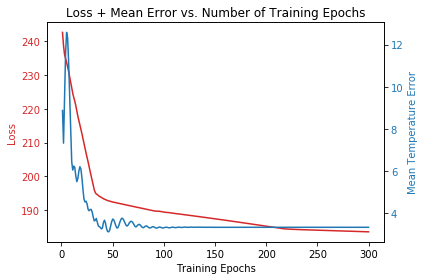

In [36]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('Loss', color=color)
ax1.plot(range(1,num_epochs+1),losses,label="Loss", color=color)
ax1.tick_params(axis='y', labelcolor=color)

plt.title("Loss + Mean Error vs. Number of Training Epochs")
plt.xlabel("Training Epochs")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("Mean Temperature Error", color=color)  # we already handled the x-label with ax1
ax2.plot(range(1,num_epochs+1),accuracies,label="Mean Temp Error", color=color)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [233]:
# Comparison to Linear Regression / Average of nodes?  TODO

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x, y)
Y_pred = linear_regressor.predict(X)  # make predictions

In [207]:
x1 = np.asarray([df['elev_meters'].values], dtype=np.float32)
x2 = np.asarray([df['AverageTemperature'].values], dtype=np.float32)

x = np.concatenate((x1, x2), axis=0)
x[:, remove]

array([[6.31850e+02, 3.31810e+02, 1.59553e+03, 3.27850e+02, 2.03050e+02,
        7.72100e+01, 9.40000e+00, 4.28370e+02, 2.07470e+02, 1.64899e+03,
        8.31300e+01, 4.00000e-01, 5.43600e+02, 0.00000e+00, 3.23030e+02],
       [2.25450e+01, 1.67890e+01, 1.62900e+01, 1.55440e+01, 1.94410e+01,
        3.76400e+00, 2.48010e+01, 1.79750e+01, 1.79560e+01, 1.28010e+01,
        1.97990e+01, 2.30980e+01, 1.34410e+01, 2.40220e+01, 1.57960e+01]],
      dtype=float32)